The results from this notebook are shown in Figure 9 in the paper. 

The initial inspiration for this plot was from https://academic.oup.com/mnras/article/531/4/3839/7687173. 

Note that to do this analysis, we: 
- Ignore upper limits. 
- Ignore measurement errors. 
- Only do this for the best estimates of distance. 
- The KS test is comparing the distribution of our DATA POINTS rather than the NS/BH populations (the latter would require correcting for multiple data points per source, and the fact that most NS observations are upper limits).

IMPORTANT: The figure is only meant to be illustrative, i.e. mostly for visual comparison. 

In [1]:
import sys
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as nps
from scipy.stats import ks_2samp
from ndtest import ks2d2s
from matplotlib.ticker import FuncFormatter
import numpy as np

sys.path.append(os.path.abspath("../0_UTILITY_FUNCTIONS/"))
from plotting import *
from get_LrLx_data import *
from plotting import *

In [2]:
## Get the interpolated data
df = get_all_LrLx_data(interp=True, save=False, rerun=False)

Source names:  ['1A 1744-361', '4U 1543-47', '4U 1630-47', 'Cen X-4', 'Cir X-1', 'EXO 1846-031', 'GRS 1739-278', 'GRS 1915+105', 'GX 339-4', 'H1743-322', 'IGR J17091-3624', 'MAXI J1348-630', 'MAXI J1631-479', 'MAXI J1803-298', 'MAXI J1807+132', 'MAXI J1810-222', 'MAXI J1816-195', 'MAXI J1820+070', 'SAX J1808.4-3658', 'SAX J1810.8-2609', 'Swift J1727.8-1613', 'Swift J1728.9-3613', 'Swift J1842.5-1124', 'Swift J1858.6-0814', 'Vela X-1', 'XTE J1701-462']


Do this analysis just for the HS/QS detections. 

In [3]:
states = ["HS", "QS"]

# Exclude all uplims 
mask = df["state"].isin(states) & (df["Fx_uplim_bool"]==False) & (df["Fr_uplim_bool"]==False) 
df_filtered = df[mask].copy()

# Exclude all uplims 
# To test how much the NS outlier is affecting things, add the following to mask: & (data["name"]!='MAXI J1816-195')
mask2 = df["state"].isin(states) & (df["Fx_uplim_bool"]==False) & (df["Fr_uplim_bool"]==False  & (df["name"]!='MAXI J1816-195') ) 

# Exclude all uplims and high uncertainty points
mask3 = df["state"].isin(states) & (df["Fx_uplim_bool"]==False) & (df["Fr_uplim_bool"]==False) & (df["Fr_unc"]/df["Fr"]<0.5) &  (np.maximum(df["Fx_unc_l"], df["Fx_unc_u"])/df["Fx"]<0.5) 


# Exclude Fx uplims and Fr uplims for BHs (include Fr uplims just for NSs) and high uncertainty points
mask4 = df["state"].isin(states) & (df["Fx_uplim_bool"]==False) & (df["class"].isin(["BH", "candidateBH"]) & df["Fr_uplim_bool"]==False) & (df["Fr_unc"]/df["Fr"]<0.5) &  (np.maximum(df["Fx_unc_l"], df["Fx_unc_u"])/df["Fx"]<0.5)


# Include uplims as detections
mask5 = df["state"].isin(states) 
df_filtered5 = df[mask5].copy()


# Testing Plotting KDEs

In [11]:
def test_kde(df_filtered):

    ## Get the BH and NS data
    mask_NS = df_filtered["class"].isin(["NS"]) 
    mask_BH = df_filtered["class"].isin(["BH", "candidateBH"]) 
    x_NS = df_filtered["Lx"][mask_NS]
    y_NS = df_filtered["Lr"][mask_NS]
    x_BH = df_filtered["Lx"][mask_BH]
    y_BH =  df_filtered["Lr"][mask_BH]


    ## Set up the plot
    fig= plt.figure(figsize=(9,6))
    ax = fig.add_subplot(1,1,1)

    ## Plot the data
    plt.scatter(x_NS, y_NS , color=colour_NS)
    plt.scatter(x_BH, y_BH, color=colour_BH)


    levels = [0.05, 0.25, 0.6, 0.9]

    ## KDE for NSs
    sns.kdeplot(
        x=x_NS,
        y= y_NS,
        ax=ax,
        levels=levels,
        color=colour_NS,
        linewidths=1,
        fill=False,
        log_scale=(True, True)
    )

    ## KDE for BHs
    sns.kdeplot(
        x=x_BH,
        y=y_BH,
        ax=ax,
        levels=levels,
        color=colour_BH,
        linewidths=1,
        fill=False,
        log_scale=(True, True)
    )

    plt.xlim([min_Lx, max_Lx])
    plt.ylim([min_Lr,max_Lr_2])
    plt.xlabel("Lx (erg/s)")
    plt.ylabel("Lr (erg/s)")
    ax.set_yscale("log", base=10)
    ax.set_xscale("log", base=10)
    ax.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=10))
    ax.xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs="auto", numticks=10))
    plt.show()


    ######
    ## Equivalent if done on a log scale

    log_x_NS = np.log10(x_NS).to_numpy()
    log_y_NS = np.log10(y_NS).to_numpy()
    log_x_BH = np.log10(x_BH).to_numpy()
    log_y_BH =  np.log10(y_BH).to_numpy()


    fig= plt.figure(figsize=(9,6))
    ax = fig.add_subplot(1,1,1)

    plt.scatter(log_x_NS, log_y_NS , color=colour_NS)
    plt.scatter(log_x_BH, log_y_BH, color=colour_BH)


    levels = [0.05, 0.25, 0.6, 0.9]

    ## KDE for NSs
    sns.kdeplot(
        x=log_x_NS,
        y= log_y_NS,
        ax=ax,
        levels=levels,
        color=colour_NS,
        linewidths=1,
        fill=False
    )

    ## KDE for BHs
    sns.kdeplot(
        x=log_x_BH,
        y=log_y_BH,
        ax=ax,
        levels=levels,
        color=colour_BH,
        linewidths=1,
        fill=False
    )

    plt.xlim([np.log10(min_Lx),np.log10(max_Lx)])
    plt.ylim([np.log10(min_Lr),np.log10(max_Lr_2)])
    plt.xlabel("log Lx (erg/s)")
    plt.ylabel("log Lr (erg/s)")
    plt.show()


    

    ## LX

    fig, (ax1, ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
    ax1.hist(log_x_NS, bins=20, alpha=0.5, label='NS Lx')
    ax1.hist(log_x_BH, bins=20, alpha=0.5, label='BH Lx')
    ax1.set_xlabel('log Lx (erg/s)')
    ax1.set_ylabel('Number of observations')
    ax1.legend()    

    ax2.hist(log_x_NS, bins=8, alpha=0.5, label='NS Lx', density=True)
    ax2.hist(log_x_BH, bins=8, alpha=0.5, label='BH Lx', density=True)
    ax2.set_xlabel('log Lx (erg/s)')
    ax2.set_ylabel('Number of observations')
    ax2.legend()  

    plt.show()


    ## LR

    fig, (ax1, ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
    ax1.hist(log_y_NS, bins=20, alpha=0.5, label='NS Lr')
    ax1.hist(log_y_BH, bins=20, alpha=0.5, label='BH Lr')
    ax1.set_xlabel('log Lr (erg/s)')
    ax1.set_ylabel('Number of observations')
    ax1.legend()    

    ax2.hist(log_y_NS, bins=8, alpha=0.5, label='NS Lr', density=True)
    ax2.hist(log_y_BH, bins=8, alpha=0.5, label='BH Lr', density=True)
    ax2.set_xlabel('log Lr (erg/s)')
    ax2.set_ylabel('Number of observations')
    ax2.legend()  

    plt.show()


    ## Testing 1D KS test

    pval_log_Lx = ks_2samp(log_x_NS, log_x_BH).pvalue
    pval_log_Lr = ks_2samp(log_y_NS, log_y_BH).pvalue

    print(f"KS test p-value for Lx distributions: {pval_log_Lx}")
    print(f"KS test p-value for Lr distributions: {pval_log_Lr}")

    pval_Lx = ks_2samp(x_NS, x_BH).pvalue
    pval_Lr = ks_2samp(y_NS, y_BH).pvalue

    print(f"KS test p-value for Lx distributions: {pval_Lx}")
    print(f"KS test p-value for Lr distributions: {pval_Lr}")


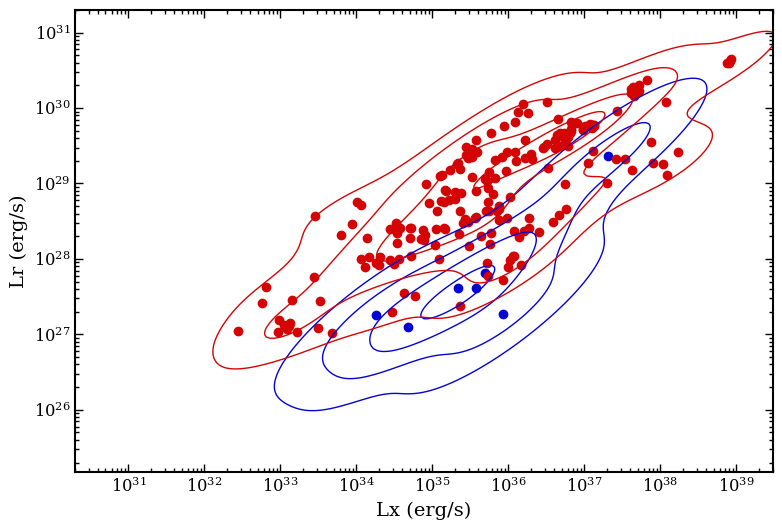

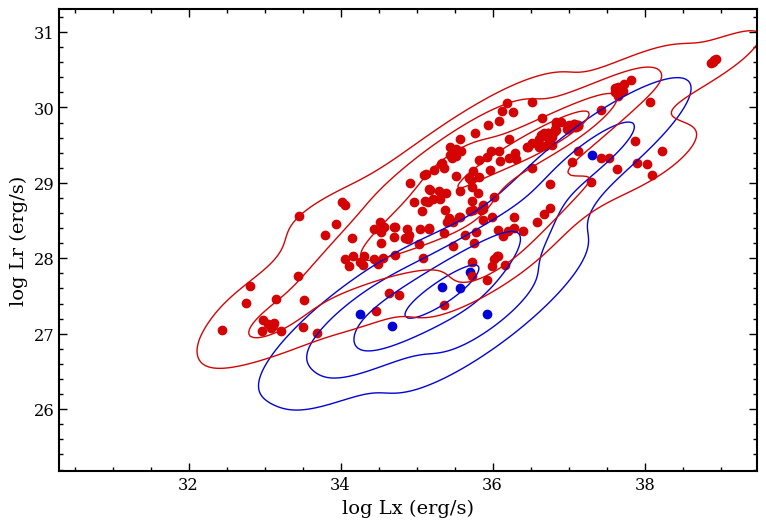

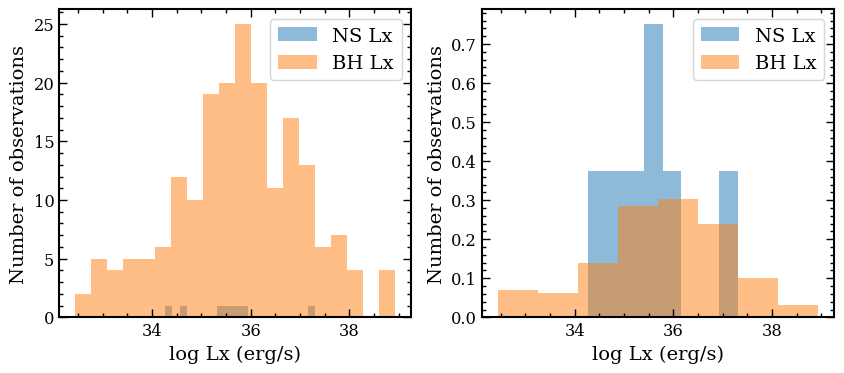

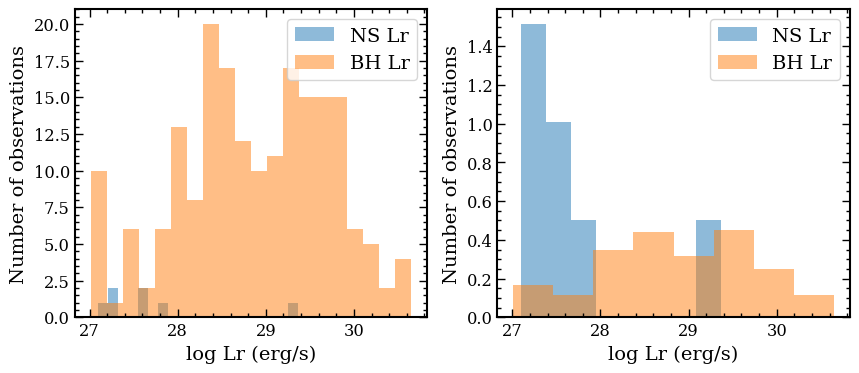

KS test p-value for Lx distributions: 0.4529108400740737
KS test p-value for Lr distributions: 0.0002010739694033891
KS test p-value for Lx distributions: 0.4529108400740737
KS test p-value for Lr distributions: 0.0002010739694033891


In [12]:
# Only detections
test_kde(df_filtered)

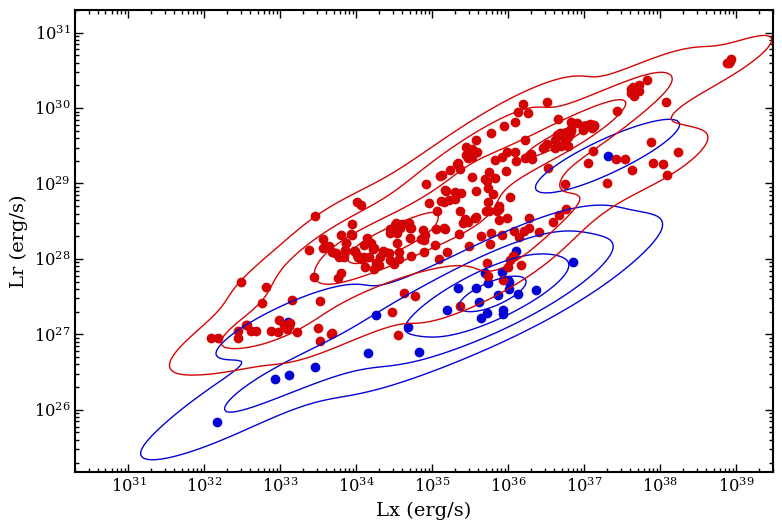

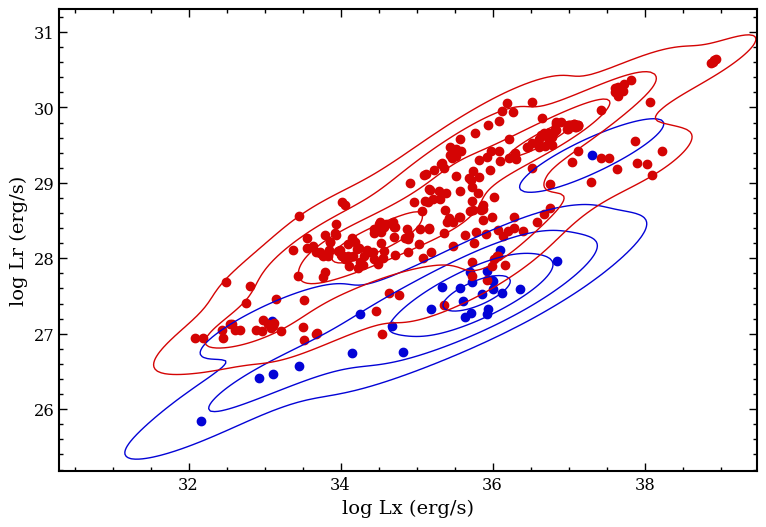

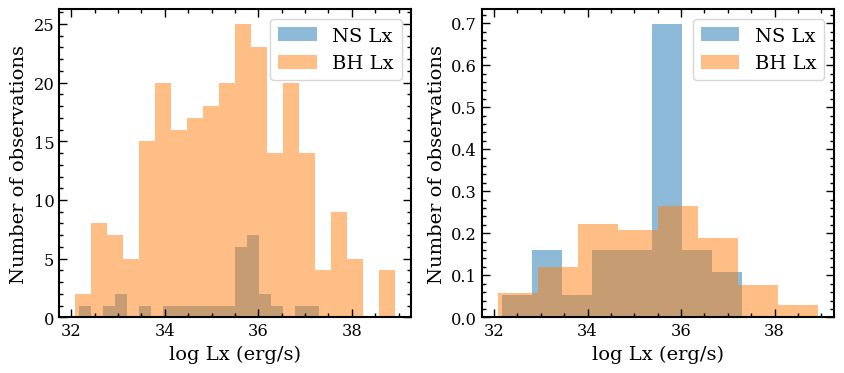

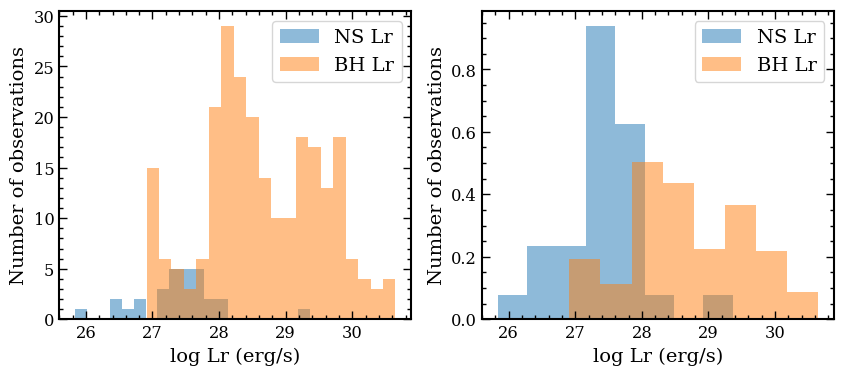

KS test p-value for Lx distributions: 0.23097798419081514
KS test p-value for Lr distributions: 1.4433978183653324e-15
KS test p-value for Lx distributions: 0.23097798419081514
KS test p-value for Lr distributions: 1.4433978183653324e-15


In [13]:
# Including upper limits as detections
test_kde(df_filtered5)

# Final Plot

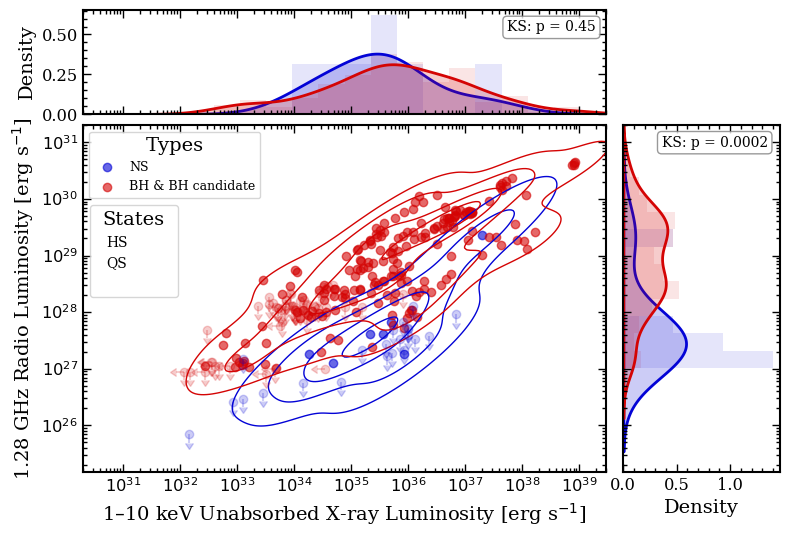

In [14]:
plot_LrLx_BH_vs_NS_detections(df)